In [200]:
import matplotlib.pyplot as plt
import numpy as np

N_CITIES = 20  
DNA_SIZE =20
CROSS_RATE = 0.5
MUTATE_RATE = 0.01
POP_SIZE = 500
N_GENERATIONS = 500

X_BOUND = [-5, 5]
Y_BOUND = [-5, 5]

In [233]:
class GA(object):
    def __init__(self, DNA_size, cross_rate, mutation_rate, pop_size,problem ):
        self.DNA_size = DNA_size
        self.cross_rate = cross_rate
        self.mutate_rate = mutation_rate
        self.pop_size = pop_size
        self.problem=problem
        if self.problem=='TSP':
            self.pop = np.vstack([np.random.permutation(DNA_size) for _ in range(pop_size)])
        if self.problem=='Minimal':
            self.pop = np.random.randint(2, size=(POP_SIZE, DNA_SIZE*2)) 

    def translateDNA(self, DNA, city_position):     # get cities' coord in order
        line_x = np.empty_like(DNA, dtype=np.float64)
        line_y = np.empty_like(DNA, dtype=np.float64)
        if self.problem=='TSP':
            for i, d in enumerate(DNA):
                city_coord = city_position[d]
                line_x[i, :] = city_coord[:, 0]
                line_y[i, :] = city_coord[:, 1]
        if self.problem=='Minimal':
            pop=DNA
            x_pop = pop[:,1::2]#奇数列表示X
            y_pop = pop[:,::2] #偶数列表示y

            #pop:(POP_SIZE,DNA_SIZE)*(DNA_SIZE,1) --> (POP_SIZE,1)
            line_x = x_pop.dot(2**np.arange(DNA_SIZE)[::-1])/float(2**DNA_SIZE-1)*(X_BOUND[1]-X_BOUND[0])+X_BOUND[0]
            line_y = y_pop.dot(2**np.arange(DNA_SIZE)[::-1])/float(2**DNA_SIZE-1)*(Y_BOUND[1]-Y_BOUND[0])+Y_BOUND[0]
        return line_x, line_y

    def get_fitness(self, line_x, line_y):
        if self.problem=='TSP':
            total_distance = np.empty((line_x.shape[0],), dtype=np.float64)
            for i, (xs, ys) in enumerate(zip(line_x, line_y)):
                total_distance[i] = np.sum(np.sqrt(np.square(np.diff(xs)) + np.square(np.diff(ys))))

                #print(line_x)
                #print("total_distance",total_distance[i])
                #print("diffx",line_x[-1]-line_x[0])

                total_distance[i]+=np.sqrt(np.square(line_x[i][-1]-line_x[i][0]) + np.square(line_y[i][-1]-line_y[i][0]))

            #res += self.matrix_distance[one_path[-1],one_path[0]]
            fitness = np.exp(self.DNA_size * 2 / total_distance)
            return fitness, total_distance
        if self.problem=='Minimal':
            pred=F(line_x,line_y)
            fitness=(pred - np.min(pred)) + 1e-3
            return fitness
        

    def select(self, fitness):
        idx = np.random.choice(np.arange(self.pop_size), size=self.pop_size, replace=True, p=fitness / fitness.sum())
        return self.pop[idx]

    def crossover(self, parent, pop):
        if np.random.rand() < self.cross_rate:
            i_ = np.random.randint(0, self.pop_size, size=1)                        # select another individual from pop
            cross_points = np.random.randint(0, 2, self.DNA_size).astype(np.bool)   # choose crossover points
            keep_city = parent[~cross_points]                                       # find the city number
            swap_city = pop[i_, np.isin(pop[i_].ravel(), keep_city, invert=True)]
            parent[:] = np.concatenate((keep_city, swap_city))
        return parent

    def mutate(self, child):
        for point in range(self.DNA_size):
            if np.random.rand() < self.mutate_rate:
                swap_point = np.random.randint(0, self.DNA_size)
                swapA, swapB = child[point], child[swap_point]
                child[point], child[swap_point] = swapB, swapA
        return child

    def crossover_and_mutation(pop, CROSSOVER_RATE = 0.8):
        new_pop = []
        for father in pop:		#遍历种群中的每一个个体，将该个体作为父亲
            child = father		#孩子先得到父亲的全部基因（这里我把一串二进制串的那些0，1称为基因）
            if np.random.rand() < CROSSOVER_RATE:			#产生子代时不是必然发生交叉，而是以一定的概率发生交叉
                mother = pop[np.random.randint(POP_SIZE)]	#再种群中选择另一个个体，并将该个体作为母亲
                cross_points = np.random.randint(low=0, high=DNA_SIZE*2)	#随机产生交叉的点
                child[cross_points:] = mother[cross_points:]		#孩子得到位于交叉点后的母亲的基因
            mutate(child)	#每个后代有一定的机率发生变异
            new_pop.append(child)

        return new_pop

    def evolve(self, fitness):
        pop = self.select(fitness)
        if self.problem=='TSP':
            
            pop_copy = pop.copy()
            for parent in pop:  # for every parent
                child = self.crossover(parent, pop_copy)
                child = self.mutate(child)
                parent[:] = child
        else:
            pop = np.array(crossover_and_mutation(pop, CROSSOVER_RATE))
            fitness = get_fitness(pop)
            pop = select(pop, fitness) #选择生成新的种群
        self.pop = pop


class TravelSalesPerson(object):
    def __init__(self, n_cities):
        self.city_position = np.random.rand(n_cities, 2) #随机生成城市
        plt.ion()

    def plotting(self, lx, ly, total_d):
        plt.cla()
        plt.scatter(self.city_position[:, 0].T, self.city_position[:, 1].T, s=100, c='k')
        plt.plot(lx.T, ly.T, 'r-')
        plt.plot([lx[-1],lx[0]],[ly[-1],ly[0]],'r')
        plt.text(-0.05, -0.05, "Total distance=%.2f" % total_d, fontdict={'size': 20, 'color': 'red'})
        plt.xlim((-0.1, 1.1))
        plt.ylim((-0.1, 1.1))
        plt.pause(0.01)



In [240]:
def F(x,y):
    return (3*(1-x)**2*np.exp(-(x**2)-(y+1)**2)- 10*(x/5 - x**3 - y**5)*np.exp(-x**2-y**2)- 1/3**np.exp(-(x+1)**2 - y**2))
def plot_3d(ax):

	X = np.linspace(*X_BOUND, 100)
	Y = np.linspace(*Y_BOUND, 100)
	X,Y = np.meshgrid(X, Y)
	Z = F(X, Y)
	ax.plot_surface(X,Y,Z,rstride=1,cstride=1,cmap=cm.coolwarm)
	ax.set_zlim(-10,10)
	ax.set_xlabel('x')
	ax.set_ylabel('y')
	ax.set_zlabel('z')
	plt.pause(3)
	plt.show()

    

In [241]:
def Minimal():
    ga=GA(DNA_size=DNA_SIZE, cross_rate=0.8, mutation_rate=0.05, pop_size=POP_SIZE,problem='Minimal')
    pop = np.random.randint(2, size=(POP_SIZE, DNA_SIZE*2)) 
    #N_GENERATIONS=500
    for generation in range(N_GENERATIONS):
        lx, ly = ga.translateDNA(ga.pop, pop)
        fitness = ga.get_fitness(lx, ly)
        ga.evolve(fitness)
        best_idx = np.argmax(fitness)
        best_z=F(lx[best_idx],ly[best_idx])
        if generation%30==0 or generation==N_GENERATIONS-1:
            print('Gen:', generation, '| best fit: %.2f' % fitness[best_idx],'| best x: %.2f' % lx[best_idx],'| best y: %.2f' % ly[best_idx],'| best z: %.2f' % best_z,)
       
            #         if generation==0 or generation==N_GENERATIONS-1:
#             env.plotting(lx[best_idx], ly[best_idx], total_distance[best_idx])


In [242]:
Minimal()

Gen: 0 | best fit: 13.88 | best x: 0.05 | best y: 1.49 | best z: -6.99
Gen: 30 | best fit: 0.46 | best x: 0.00 | best y: 1.54 | best z: -7.13
Gen: 60 | best fit: 0.01 | best x: 0.00 | best y: 1.56 | best z: -7.14
Gen: 90 | best fit: 0.07 | best x: 0.00 | best y: 1.56 | best z: -7.14
Gen: 120 | best fit: 0.00 | best x: 0.00 | best y: 1.56 | best z: -7.14
Gen: 150 | best fit: 0.14 | best x: 0.00 | best y: 1.56 | best z: -7.14
Gen: 180 | best fit: 0.00 | best x: 0.00 | best y: 1.56 | best z: -7.14
Gen: 210 | best fit: 0.00 | best x: 0.00 | best y: 1.56 | best z: -7.14
Gen: 240 | best fit: 0.23 | best x: 0.00 | best y: 1.56 | best z: -7.14
Gen: 270 | best fit: 0.00 | best x: 0.00 | best y: 1.56 | best z: -7.14
Gen: 300 | best fit: 0.00 | best x: 0.00 | best y: 1.56 | best z: -7.14
Gen: 330 | best fit: 0.00 | best x: 0.00 | best y: 1.56 | best z: -7.14
Gen: 360 | best fit: 0.01 | best x: 0.00 | best y: 1.56 | best z: -7.14
Gen: 390 | best fit: 0.00 | best x: 0.00 | best y: 1.56 | best z: -7

In [144]:
def TSP():
    ga = GA(DNA_size=N_CITIES, cross_rate=CROSS_RATE, mutation_rate=MUTATE_RATE, pop_size=POP_SIZE,problem='TSP')
    distance=[]
    env = TravelSalesPerson(N_CITIES)
    for generation in range(N_GENERATIONS):
        lx, ly = ga.translateDNA(ga.pop, env.city_position)
        fitness, total_distance = ga.get_fitness(lx, ly)
        ga.evolve(fitness)
        best_idx = np.argmax(fitness)
        best_dis=total_distance[best_idx]
        distance.append(best_dis)
        if generation%30==0 or generation==N_GENERATIONS-1:
            print('Gen:', generation, '| best fit: %.2f' % fitness[best_idx],)
        if generation==0 or generation==N_GENERATIONS-1:
            env.plotting(lx[best_idx], ly[best_idx], total_distance[best_idx])

    plt.ioff()
    plt.show()
    # 目标函数变化曲线
    y1=distance
    y2=fitness
    x=list(range(len(distance)))
    plt.plot(x,y1)
    plt.show()

Gen: 0 | best fit: 325.96


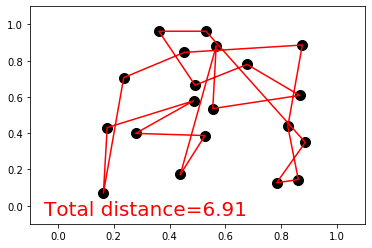

Gen: 30 | best fit: 2405.10
Gen: 60 | best fit: 3035.09
Gen: 90 | best fit: 8834.58
Gen: 120 | best fit: 9034.69
Gen: 150 | best fit: 9034.69
Gen: 180 | best fit: 9034.69
Gen: 210 | best fit: 11026.03
Gen: 240 | best fit: 13813.56
Gen: 270 | best fit: 13813.56
Gen: 300 | best fit: 14045.26
Gen: 330 | best fit: 13813.56
Gen: 360 | best fit: 13813.56
Gen: 390 | best fit: 13813.56
Gen: 420 | best fit: 13813.56
Gen: 450 | best fit: 13813.56
Gen: 480 | best fit: 13813.56
Gen: 499 | best fit: 13813.56


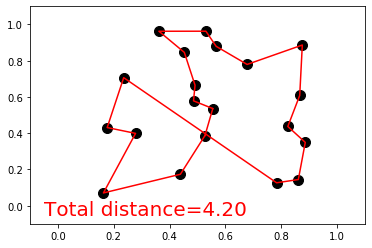

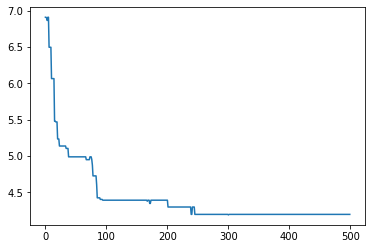

In [146]:
TSP()

In [111]:
from math import floor
import numpy as np
import matplotlib.pyplot as plt #导入所需要的库

class Gena_TSP(object):
    def __init__(self,data,maxgen=200,size_pop=200,cross_prob=0.9,pmuta_prob=0.01,select_prob=0.8):
        self.maxgen = maxgen #最大迭代次数
        self.size_pop = size_pop  #群体个数
        self.cross_prob = cross_prob #交叉概率
        self.pmuta_prob = pmuta_prob #变异概率
        self.select_prob = select_prob #选择概率
        
        self.data = data   #城市的左边数据
        self.num =len(data) #城市个数 对应染色体长度
        
        self.matrix_distance = self.matrix_dis() 
       #距离矩阵n*n, 第[i,j]个元素表示城市i到j距离matrix_dis函数见下文
        
        self.select_num = max(floor(self.size_pop*self.select_prob+0.5),2) 
       #通过选择概率确定子代的选择个数

        self.chrom = np.array([0]*self.size_pop*self.num).reshape(self.size_pop,self.num)
        self.sub_sel = np.array([0]*self.select_num*self.num).reshape(self.select_num,self.num)
        #父代和子代群体的初始化（不直接用np.zeros是为了保证单个染色体的编码为整数，np.zeros对应的数据类型为浮点型）   
        
        self.fitness = np.zeros(self.size_pop)
        #存储群体中每个染色体的路径总长度，对应单个染色体的适应度就是其倒数

        self.best_fit = []
        self.best_path= []
        #保存每一步的群体的最优路径和距离
    
    # 城市间距离函数
    def matrix_dis(self):
        res = np.zeros((self.num,self.num))
        for i in range(self.num):
            for j in range(i+1,self.num):
                res[i,j] = np.linalg.norm(self.data[i,:]-self.data[j,:])
                res[j,i] = res[i,j]
        return res
    # 随机产生初始化群体函数
    def rand_chrom(self):
        rand_ch = np.array(range(self.num))
        for i in range(self.size_pop):
            np.random.shuffle(rand_ch)
            self.chrom[i,:]= rand_ch
            self.fitness[i] = self.comp_fit(rand_ch)
            
    def comp_fit(self, one_path):
        res = 0
        for i in range(self.num-1):
            res += self.matrix_distance[one_path[i],one_path[i+1]]
        res += self.matrix_distance[one_path[-1],one_path[0]]
        return res
    # 路径可视化    
    def out_path(self, one_path):
        res = str(one_path[0]+1)+'-->'
        for i in range(1, self.num):
            res += str(one_path[i]+1)+'-->'
        res += str(one_path[0]+1)+'\n'
        print(res)

    def select_sub(self):
        fit = 1./(self.fitness) #适应度函数
        cumsum_fit = np.cumsum(fit)
        pick = cumsum_fit[-1]/self.select_num*(np.random.rand()+np.array(range(self.select_num)))
        i,j = 0,0
        index = []
        while i<self.size_pop and j<self.select_num:
            if cumsum_fit[i]>= pick[j]:
                index.append(i)
                j += 1
            else:
                i += 1
        self.sub_sel = self.chrom[index,:]
        
    def cross_sub(self):
        if self.select_num%2 == 0:
            num = range(0,self.select_num,2)
        else:
            num = range(0,self.select_num-1,2)
        for i in num:
            if self.cross_prob>=np.random.rand():
                self.sub_sel[i,:],self.sub_sel[i+1,:] = self.intercross(self.sub_sel[i,:],self.sub_sel[i+1,:])
    # 交叉           
    def intercross(self,ind_a,ind_b):
        r1 = np.random.randint(self.num)
        r2 = np.random.randint(self.num)
        while r2 == r1:
            r2 = np.random.randint(self.num)
        left,right = min(r1,r2),max(r1,r2)
        ind_a1 = ind_a.copy()
        ind_b1 = ind_b.copy()
        for i in range(left,right+1):
            ind_a2 = ind_a.copy()
            ind_b2 = ind_b.copy()
            ind_a[i] = ind_b1[i] 
            ind_b[i] = ind_a1[i]
            x = np.argwhere(ind_a==ind_a[i])
            y = np.argwhere(ind_b==ind_b[i])
            if len(x) == 2:
                ind_a[x[x!=i]] = ind_a2[i]
            if len(y) == 2:
                ind_b[y[y!=i]] = ind_b2[i]
        return ind_a,ind_b
    # 变异 
    def mutation_sub(self):
        for i in range(self.select_num):
            if np.random.rand() <= self.cross_prob:
                r1 = np.random.randint(self.num)
                r2 = np.random.randint(self.num)
                while r2 == r1:
                    r2 = np.random.randint(self.num)
                self.sub_sel[i,[r1,r2]] = self.sub_sel[i,[r2,r1]]
                
    def reverse_sub(self):
        for i in range(self.select_num):
            r1 = np.random.randint(self.num)
            r2 = np.random.randint(self.num)
            while r2 == r1:
                r2 = np.random.randint(self.num)
            left,right = min(r1,r2),max(r1,r2)
            sel = self.sub_sel[i,:].copy()
            
            sel[left:right+1] = self.sub_sel[i,left:right+1][::-1]
            if self.comp_fit(sel) < self.comp_fit(self.sub_sel[i,:]):
                self.sub_sel[i,:] = sel
    def reins(self):
        index = np.argsort(self.fitness)[::-1]
        self.chrom[index[:self.select_num],:] = self.sub_sel
                
def main(data):
    Path_short = Gena_TSP(data) #根据位置坐标，生成一个遗传算法类
    Path_short.rand_chrom()  #初始化父类

    ## 绘制初始化的路径图
    fig,ax=plt.subplots()
    x = data[:,0]
    y = data[:,1]
    ax.scatter(x, y,linewidths=0.1)
    for i,txt in enumerate(range(1,len(data)+1)):
        ax.annotate(txt,(x[i],y[i]))
    res0 = Path_short.chrom[0]
    x0 = x[res0]
    y0 = y[res0]
    for i in range(len(data)-1):
        plt.quiver(x0[i], y0[i],x0[i+1]-x0[i], y0[i+1]-y0[i], color='r', width=0.005,angles='xy',scale=1, scale_units='xy')  
    plt.quiver(x0[-1], y0[-1],x0[0]-x0[-1], y0[0]-y0[-1], color='r', width=0.005,angles='xy',scale=1, scale_units='xy')
    plt.show()
    print('初始染色体的路程: '+str( Path_short.fitness[0]))

    #循环迭代遗传过程
    for i in range(Path_short.maxgen):
        Path_short.select_sub()   #选择子代
        Path_short.cross_sub()    #交叉
        Path_short.mutation_sub() #变异
        Path_short.reverse_sub()  #进化逆转
        Path_short.reins()        #子代插入

        #重新计算新群体的距离值
        for j in range(Path_short.size_pop):
            Path_short.fitness[j] = Path_short.comp_fit(Path_short.chrom[j,:])
         
        #每隔三十步显示当前群体的最优路径
        index = Path_short.fitness.argmin()
#         if (i+1)%30 == 0 :
#             print('第'+str(i+1)+'步后的最短的路程: '+str( Path_short.fitness[index]))
#             print('第'+str(i+1)+'步后的最优路径:')
#             Path_short.out_path(Path_short.chrom[index,:])# 显示每一步的最优路径
        
        #存储每一步的最优路径及距离
        Path_short.best_fit.append(Path_short.fitness[index])
        Path_short.best_path.append(Path_short.chrom[index,:])
    
        if i==Path_short.maxgen-1:
            fig,ax=plt.subplots()
            x = data[:,0]
            y = data[:,1]
            ax.scatter(x, y,linewidths=0.1)
            for i,txt in enumerate(range(1,len(data)+1)):
                ax.annotate(txt,(x[i],y[i]))
            res0 = Path_short.chrom[Path_short.maxgen-1,:]
            x0 = x[res0]
            y0 = y[res0]
            print(x0)
            print(y0)
            print(res0)
            for i in range(len(data)-1):
                plt.quiver(x0[i], y0[i],x0[i+1]-x0[i], y0[i+1]-y0[i], color='r', width=0.005,angles='xy',scale=1, scale_units='xy')  
            plt.quiver(x0[-1], y0[-1],x0[0]-x0[-1], y0[0]-y0[-1], color='r', width=0.005,angles='xy',scale=1, scale_units='xy')
            plt.show()
            print('最终染色体的路程: '+str( Path_short.fitness[0]))
            
            y=Path_short.best_fit
            x=list(range(len(Path_short.best_fit)))
            plt.plot(x,y)
            plt.show()
    return Path_short  #返回遗传算法结果类

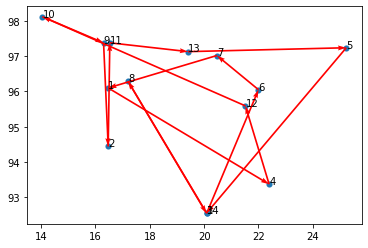

初始染色体的路程: 60.08737280871547
[20.09 14.05 16.3  16.53 17.2  19.41 20.47 21.52 22.   25.23 22.39 16.47
 16.47 20.09]
[92.55 98.12 97.38 97.38 96.29 97.13 97.02 95.59 96.05 97.24 93.37 94.44
 96.1  92.54]
[13  9  8 10  7 12  6 11  5  4  3  1  0  2]


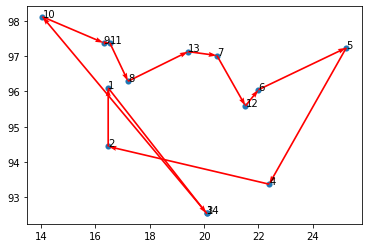

最终染色体的路程: 29.340520066994227


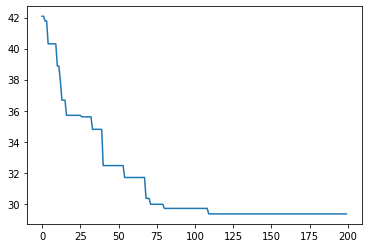

In [113]:
data = np.array([16.47,96.10,16.47,94.44,20.09,92.54,
    22.39,93.37,25.23,97.24,22.00,96.05,20.47,97.02,
    17.20,96.29,16.30,97.38,14.05,98.12,16.53,97.38,
    21.52,95.59,19.41,97.13,20.09,92.55]).reshape(14,2)

main(data)

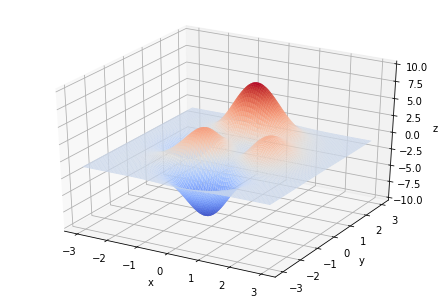

max_fitness: 0.009101328630957917
最优的基因型： [1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0
 1 1 0 1 1 0 0 1 0 1 1]
(x, y): (0.001754343614241094, 1.5702079874401083)


In [154]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

DNA_SIZE = 24
POP_SIZE = 200
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.005
N_GENERATIONS = 50
X_BOUND = [-3, 3]
Y_BOUND = [-3, 3]


def F(x, y):
	return 3*(1-x)**2*np.exp(-(x**2)-(y+1)**2)- 10*(x/5 - x**3 - y**5)*np.exp(-x**2-y**2)- 1/3**np.exp(-(x+1)**2 - y**2)

def plot_3d(ax):

	X = np.linspace(*X_BOUND, 100)
	Y = np.linspace(*Y_BOUND, 100)
	X,Y = np.meshgrid(X, Y)
	Z = F(X, Y)
	ax.plot_surface(X,Y,Z,rstride=1,cstride=1,cmap=cm.coolwarm)
	ax.set_zlim(-10,10)
	ax.set_xlabel('x')
	ax.set_ylabel('y')
	ax.set_zlabel('z')
	plt.pause(3)
	plt.show()


def get_fitness(pop): 
    x,y = translateDNA(pop)
    pred = F(x, y)
    return (pred - np.min(pred)) + 1e-3 #减去最小的适应度是为了防止适应度出现负数，通过这一步fitness的范围为[0, np.max(pred)-np.min(pred)],最后在加上一个很小的数防止出现为0的适应度


def translateDNA(pop): #pop表示种群矩阵，一行表示一个二进制编码表示的DNA，矩阵的行数为种群数目
	x_pop = pop[:,1::2]#奇数列表示X
	y_pop = pop[:,::2] #偶数列表示y
	
	#pop:(POP_SIZE,DNA_SIZE)*(DNA_SIZE,1) --> (POP_SIZE,1)
	x = x_pop.dot(2**np.arange(DNA_SIZE)[::-1])/float(2**DNA_SIZE-1)*(X_BOUND[1]-X_BOUND[0])+X_BOUND[0]
	y = y_pop.dot(2**np.arange(DNA_SIZE)[::-1])/float(2**DNA_SIZE-1)*(Y_BOUND[1]-Y_BOUND[0])+Y_BOUND[0]
	return x,y

def crossover_and_mutation(pop, CROSSOVER_RATE = 0.8):
	new_pop = []
	for father in pop:		#遍历种群中的每一个个体，将该个体作为父亲
		child = father		#孩子先得到父亲的全部基因（这里我把一串二进制串的那些0，1称为基因）
		if np.random.rand() < CROSSOVER_RATE:			#产生子代时不是必然发生交叉，而是以一定的概率发生交叉
			mother = pop[np.random.randint(POP_SIZE)]	#再种群中选择另一个个体，并将该个体作为母亲
			cross_points = np.random.randint(low=0, high=DNA_SIZE*2)	#随机产生交叉的点
			child[cross_points:] = mother[cross_points:]		#孩子得到位于交叉点后的母亲的基因
		mutation(child)	#每个后代有一定的机率发生变异
		new_pop.append(child)

	return new_pop

def mutation(child, MUTATION_RATE=0.003):
	if np.random.rand() < MUTATION_RATE: 				#以MUTATION_RATE的概率进行变异
		mutate_point = np.random.randint(0, DNA_SIZE)	#随机产生一个实数，代表要变异基因的位置
		child[mutate_point] = child[mutate_point]^1 	#将变异点的二进制为反转

def select(pop, fitness):    # nature selection wrt pop's fitness
    idx = np.random.choice(np.arange(POP_SIZE), size=POP_SIZE, replace=True,
                           p=(fitness)/(fitness.sum()) )
    return pop[idx]

def print_info(pop):
	fitness = get_fitness(pop)
	max_fitness_index = np.argmax(fitness)
	print("max_fitness:", fitness[max_fitness_index])
	x,y = translateDNA(pop)
	print("最优的基因型：", pop[max_fitness_index])
	print("(x, y):", (x[max_fitness_index], y[max_fitness_index]))


if __name__ == "__main__":
	fig = plt.figure()
	ax = Axes3D(fig)	
	plt.ion()#将画图模式改为交互模式，程序遇到plt.show不会暂停，而是继续执行
	plot_3d(ax)

	pop = np.random.randint(2, size=(POP_SIZE, DNA_SIZE*2)) #matrix (POP_SIZE, DNA_SIZE)
	for _ in range(N_GENERATIONS):#迭代N代
		x,y = translateDNA(pop)
		if 'sca' in locals(): 
			sca.remove()
		sca = ax.scatter(x, y, F(x,y), c='black', marker='o');plt.show();plt.pause(0.1)
		pop = np.array(crossover_and_mutation(pop, CROSSOVER_RATE))
		#F_values = F(translateDNA(pop)[0], translateDNA(pop)[1])#x, y --> Z matrix
		fitness = get_fitness(pop)
		pop = select(pop, fitness) #选择生成新的种群
	
	print_info(pop)
	plt.ioff()
	plot_3d(ax)